Varad Shinde \\
12141730


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torchvision
import random
import torch.nn as nn
import math

import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data

from copy import deepcopy

In [ ]:
# Meta learning parameters.

N = 5
support_size = 1
query_size = 15
meta_inner_lr = 0.4
meta_outer_lr = 0.001

In [ ]:
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_dataset = torchvision.datasets.Omniglot('./data/omniglot/', download = True, background = True, transform = transform)
test_dataset = torchvision.datasets.Omniglot('./data/omniglot/', download = True, background = False, transform = transform)

train_labels = np.repeat(np.arange(964), 20)
test_labels = np.repeat(np.arange(659), 20)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class BatchSampler(object):
    '''
    BatchSampler: yield a batch of indexes at each iteration.
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, labels, classes_per_it, support_size, query_size, iterations, batch_size):
        super(BatchSampler, self).__init__()
        self.labels = labels
        self.classes_per_it = classes_per_it
        self.support_size = support_size
        self.query_size = query_size
        self.iterations = iterations
        self.batch_size = batch_size

    def __iter__(self):
        '''
        yield a batch of indexes
        '''

        for it in range(self.iterations):
            total_batch_indexes = np.array([])

            unique_labels = np.unique(self.labels)
            for _ in range(self.batch_size):
                random_classes = np.random.choice(unique_labels, size=N, replace=False)
                support_seq = np.array([])
                query_seq = np.array([])
                for i, c in enumerate(random_classes):
                    count = self.support_size + self.query_size
                    random_indices = np.random.choice(np.arange(20*c, 20*c+20), size=count, replace=False)
                    support_seq = np.concatenate((support_seq, random_indices[:self.support_size]))
                    query_seq = np.concatenate((query_seq, random_indices[self.support_size:]))
                np.random.shuffle(support_seq)
                np.random.shuffle(query_seq)
                total_batch_indexes = np.concatenate((total_batch_indexes, support_seq, query_seq))
            yield total_batch_indexes.astype(int)

    def __len__(self):
        return self.iterations

In [ ]:
iterations = 500
batch_size = 1

train_sampler = BatchSampler(labels=train_labels, classes_per_it=N,
                              support_size=support_size, query_size=query_size, iterations=iterations,
                              batch_size=batch_size)

test_sampler = BatchSampler(labels=test_labels, classes_per_it=N,
                              support_size=support_size, query_size=query_size, iterations=iterations,
                              batch_size=batch_size)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_sampler)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_sampler)

## Model


In [ ]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels, momentum=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

class Feature_extractor(nn.Module):
    '''
    source: https://github.com/jakesnell/prototypical-networks/blob/f0c48808e496989d01db59f86d4449d7aee9ab0c/protonets/models/few_shot.py#L62-L84
    '''
    def __init__(self, x_dim=1, hid_dim=64):
        super(Feature_extractor, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim)
        )

    def forward(self, x):
        return self.encoder(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = Feature_extractor()
feature_extractor = feature_extractor.to(device)
feature_extractor.load_state_dict(torch.load('./pretrained_model.pt', map_location=device))

<All keys matched successfully>

In [ ]:
class Learner(nn.Module):

    def __init__(self, *args, **kwargs):
        super(Learner, self).__init__()

        # this dict contains all tensors needed to be optimized
        self.vars = nn.ParameterList()
        # running_mean and running_var
        self.vars_bn = nn.ParameterList()

        self.config = kwargs['config']

        for i, (name, param) in enumerate(self.config):

            if name is 'conv2d':
                w = nn.Parameter(torch.ones(*param[:4]))
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'bn':
                w = nn.Parameter(torch.ones(param[0]))
                self.vars.append(w)
                self.vars.append(nn.Parameter(torch.zeros(param[0])))
                running_mean = nn.Parameter(torch.zeros(param[0]), requires_grad=False)
                running_var = nn.Parameter(torch.ones(param[0]), requires_grad=False)
                self.vars_bn.extend([running_mean, running_var])

            elif name is 'linear':
                w = nn.Parameter(torch.ones(*param))
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                self.vars.append(nn.Parameter(torch.zeros(param[0])))


    def forward(self, x, vars=None, bn_training=True):

        if vars is None:
            vars = self.vars
        idx = 0
        bn_idx = 0

        for name, param in self.config:
            if name is 'conv2d':
                w, b = vars[idx], vars[idx + 1]
                x = F.conv2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
            elif name is 'bn':
                w, b = vars[idx], vars[idx + 1]
                running_mean, running_var = self.vars_bn[bn_idx], self.vars_bn[bn_idx+1]
                x = F.batch_norm(x, running_mean, running_var, weight=w, bias=b, training=bn_training)
                idx += 2
                bn_idx += 2
            elif name is 'linear':
                w, b = vars[idx], vars[idx + 1]
                x = F.linear(x, w, b)
                idx += 2
            elif name is 'flatten':
                x = x.view(x.size(0), -1)
            elif name is 'relu':
                x = F.relu(x, inplace=param[0])
            elif name is 'max_pool2d':
                x = F.max_pool2d(x, param[0], param[1], param[2])

        # Check correctness
        assert idx == len(vars)
        assert bn_idx == len(self.vars_bn)
        return x


    def zero_grad(self, vars=None):

        with torch.no_grad():
            if vars is None:
                for p in self.vars:
                    if p.grad is not None:
                        p.grad.zero_()
            else:
                for p in vars:
                    if p.grad is not None:
                        p.grad.zero_()

    def parameters(self):
        return self.vars

In [ ]:
class Meta(nn.Module):
    def __init__(self, *args, **kwargs):

        super(Meta, self).__init__()

        self.config = kwargs['config']
        self.update_lr = kwargs['inner_lr']
        self.finetune_steps = kwargs['finetune_steps']
        self.net = Learner(config=self.config)


    def forward(self, x_support, y_support, x_query, fc=True):
        batch_size, support_size, c, h, w = x_support.shape
        _, query_size, _, _, _ = x_query.shape
        n_way = len(torch.unique(y_support[0]))
        outputs = torch.zeros((batch_size, query_size, n_way)).to(x_support.device)

        for i in range(batch_size):
            x = x_support[i]                    # x: (s, c, h, w)
            y = y_support[i]                    # y: (s, )
            weights = self.net.parameters()
            for j in range(0, self.finetune_steps):
                features = x
                if fc:
                    features = feature_extractor(x)
                logits = self.net(features, weights, bn_training=True)
                loss = F.cross_entropy(logits, y)
                # print(j, loss)
                grad = torch.autograd.grad(loss, weights)
                weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, weights)))
            features = x_query[i]
            if fc:
                features = feature_extractor(x_query[i])
            logits_q = self.net(features, weights, bn_training=True)
            outputs[i, :, :] = logits_q

        return outputs


## With Feature Extractor

### Train

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train(model, epochs, train_dataloader):

    meta_optim = optim.Adam(model.parameters(), lr=1e-3)
    log_every_iter = 50

    model.train()
    for epoch in range(epochs):

        running_loss = 0
        running_accuracy = 0
        for i, data in enumerate(train_dataloader):

            # Prepare input data
            x, y = data
            img_size = x.shape[1:]
            x = x.reshape((batch_size, -1, *img_size))
            y = y.reshape((batch_size, -1))
            for j in range(y.shape[0]):
                _, new_labels = torch.unique(y[j, :], return_inverse=True)
                y[j, :] = new_labels

            # To GPU
            x = x.to(device)
            y = y.to(device)
            supports = x[:, :N*support_size, :, :, :]
            queries = x[:, N*support_size:, :, :, :]
            support_labels = y[:, :N*support_size]
            query_labels = y[:, N*support_size:]

            # Forward Pass
            outputs = model(supports, support_labels, queries)
            loss = F.cross_entropy(outputs.reshape((-1, N)), query_labels.reshape((-1, )))
            with torch.no_grad():
                preds = outputs.argmax(dim=2)
                acc = ((preds == query_labels) * 1.0).mean()

            # Backward and parameter update
            meta_optim.zero_grad()
            loss.backward()
            meta_optim.step()

            # Keep metrics
            running_loss += loss.item()
            running_accuracy += acc.item()

            if i % log_every_iter == log_every_iter - 1:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/log_every_iter:.3f}, \
                        accuracy = {running_accuracy/log_every_iter:.3f}')
                running_loss = 0.0
                running_accuracy = 0.0

def test(model, test_dataloader):

    running_accuracy = 0
    model.eval()
    for data in test_dataloader:

        # Prepare input data
        x, y = data
        img_size = x.shape[1:]
        x = x.reshape((batch_size, -1, *img_size))
        y = y.reshape((batch_size, -1))
        for j in range(y.shape[0]):
            _, new_labels = torch.unique(y[j, :], return_inverse=True)
            y[j, :] = new_labels

        # To GPU
        x = x.to(device)
        y = y.to(device)
        supports = x[:, :N*support_size, :, :, :]
        queries = x[:, N*support_size:, :, :, :]
        support_labels = y[:, :N*support_size]
        query_labels = y[:, N*support_size:]

        # Forward Pass
        outputs = model(supports, support_labels, queries)
        preds = outputs.argmax(dim=2)
        acc = ((preds == query_labels) * 1.0).mean()

        # Keep metrics
        running_accuracy += acc.item()

    acc = running_accuracy / len(test_dataloader)
    print('')
    print(f'Test accuracy is : {acc:.3f}')
    print('------------------------------------------')
    return acc

# -------------------------------------------

epochs = 5
config = [
    ('conv2d', [64, 64, 3, 3, 1, 1]),
    ('bn', [64]),
    ('relu', [True]),
    ('max_pool2d', [2, 2, 0]),
    ('flatten', []),
    ('linear', [N, 64])
]
update_steps = [1, 2, 3]
accuracies = []
print('Number of iterations in each epoch: {}'.format(len(train_dataloader)))
print('Number of testing iterations: {}'.format(len(test_dataloader)))
print('Training started ...')
for us in update_steps:
    print(f'--------------- number inner updates = {us} ---------------')
    model = Meta(config=config, inner_lr=4e-1, finetune_steps=us).to(device)
    train(model=model, epochs=epochs, train_dataloader=train_dataloader)
    acc = test(model=model, test_dataloader=test_dataloader)
    accuracies.append(acc)


Number of iterations in each epoch: 500
Number of testing iterations: 500
Training started ...
--------------- number inner updates = 1 ---------------
[1,    50] loss: 3.144,                         accuracy = 0.503
[1,   100] loss: 1.634,                         accuracy = 0.527
[1,   150] loss: 1.378,                         accuracy = 0.483
[1,   200] loss: 1.332,                         accuracy = 0.523
[1,   250] loss: 1.285,                         accuracy = 0.571
[1,   300] loss: 1.267,                         accuracy = 0.577
[1,   350] loss: 1.220,                         accuracy = 0.631
[1,   400] loss: 1.221,                         accuracy = 0.622
[1,   450] loss: 1.191,                         accuracy = 0.626
[1,   500] loss: 1.171,                         accuracy = 0.651
[2,    50] loss: 1.107,                         accuracy = 0.666
[2,   100] loss: 1.128,                         accuracy = 0.643
[2,   150] loss: 1.089,                         accuracy = 0.666
[2,

### Plot

Plot accuracy of meta-test phase based on inner loop update parameter.

Text(0, 0.5, 'Accuracy on test data')

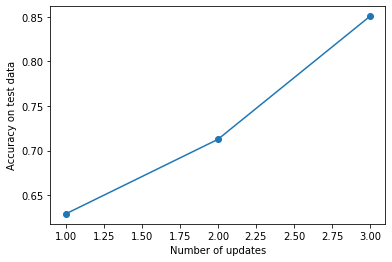

In [ ]:
plt.plot([1, 2, 3], accuracies)
plt.scatter([1, 2, 3], accuracies)
plt.xlabel('Number of updates')
plt.ylabel('Accuracy on test data')

## Without Feature Extractor

### Train


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train_complete(model, epochs, train_dataloader):

    meta_optim = optim.Adam(model.parameters(), lr=meta_outer_lr)
    log_every_iter = 50

    model.train()
    for epoch in range(epochs):

        running_loss = 0
        running_accuracy = 0
        for i, data in enumerate(train_dataloader):

            # Prepare input data
            x, y = data
            img_size = x.shape[1:]
            x = x.reshape((batch_size, -1, *img_size))
            y = y.reshape((batch_size, -1))
            for j in range(y.shape[0]):
                _, new_labels = torch.unique(y[j, :], return_inverse=True)
                y[j, :] = new_labels

            # To GPU
            x = x.to(device)
            y = y.to(device)
            supports = x[:, :N*support_size, :, :, :]
            queries = x[:, N*support_size:, :, :, :]
            support_labels = y[:, :N*support_size]
            query_labels = y[:, N*support_size:]

            # Forward Pass
            outputs = model(supports, support_labels, queries, fc=False)
            loss = F.cross_entropy(outputs.reshape((-1, N)), query_labels.reshape((-1, )))
            preds = outputs.argmax(dim=2)
            acc = ((preds == query_labels) * 1.0).mean()

            # Backward and parameter update
            meta_optim.zero_grad()
            loss.backward()
            meta_optim.step()

            # Keep metrics
            running_loss += loss.item()
            running_accuracy += acc.item()

            if i % log_every_iter == log_every_iter - 1:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/log_every_iter:.3f}, \
                        accuracy = {running_accuracy/log_every_iter:.3f}')
                running_loss = 0.0
                running_accuracy = 0.0

def test_complete(model, test_dataloader):

    running_accuracy = 0
    model.eval()
    for data in test_dataloader:

        # Prepare input data
        x, y = data
        img_size = x.shape[1:]
        x = x.reshape((batch_size, -1, *img_size))
        y = y.reshape((batch_size, -1))
        for j in range(y.shape[0]):
            _, new_labels = torch.unique(y[j, :], return_inverse=True)
            y[j, :] = new_labels

        # To GPU
        x = x.to(device)
        y = y.to(device)
        supports = x[:, :N*support_size, :, :, :]
        queries = x[:, N*support_size:, :, :, :]
        support_labels = y[:, :N*support_size]
        query_labels = y[:, N*support_size:]

        # Forward Pass
        outputs = model(supports, support_labels, queries, fc=False)
        preds = outputs.argmax(dim=2)
        acc = ((preds == query_labels) * 1.0).mean()

        # Keep metrics
        running_accuracy += acc.item()

    acc = running_accuracy / len(test_dataloader)
    print('')
    print(f'Test accuracy is : {acc:.3f}')
    print('------------------------------------------')
    return acc

epochs = 10
config = [
    ('conv2d', [64, 1, 3, 3, 1, 1]),
    ('bn', [64]),
    ('relu', [True]),
    ('max_pool2d', [2, 2, 0]),
    ('conv2d', [64, 64, 3, 3, 1, 1]),
    ('bn', [64]),
    ('relu', [True]),
    ('max_pool2d', [2, 2, 0]),
    ('conv2d', [64, 64, 3, 3, 1, 1]),
    ('bn', [64]),
    ('relu', [True]),
    ('max_pool2d', [2, 2, 0]),
    ('conv2d', [64, 64, 3, 3, 1, 1]),
    ('bn', [64]),
    ('relu', [True]),
    ('max_pool2d', [2, 2, 0]),
    ('flatten', []),
    ('linear', [N, 64])
]
print('Number of iterations in each epoch: {}'.format(len(train_dataloader)))
print('Number of testing iterations: {}'.format(len(test_dataloader)))
print('Training started ...')
model = Meta(config=config, inner_lr=meta_inner_lr, finetune_steps=1).to(device)
train_complete(model=model, epochs=epochs, train_dataloader=train_dataloader)
acc = test_complete(model=model, test_dataloader=test_dataloader)

Number of iterations in each epoch: 500
Number of testing iterations: 500
Training started ...
[1,    50] loss: 2.686,                         accuracy = 0.372
[1,   100] loss: 1.499,                         accuracy = 0.398
[1,   150] loss: 1.456,                         accuracy = 0.428
[1,   200] loss: 1.415,                         accuracy = 0.458
[1,   250] loss: 1.401,                         accuracy = 0.454
[1,   300] loss: 1.322,                         accuracy = 0.479
[1,   350] loss: 1.290,                         accuracy = 0.521
[1,   400] loss: 1.228,                         accuracy = 0.559
[1,   450] loss: 1.173,                         accuracy = 0.574
[1,   500] loss: 1.153,                         accuracy = 0.560
[2,    50] loss: 1.070,                         accuracy = 0.612
[2,   100] loss: 1.000,                         accuracy = 0.644
[2,   150] loss: 0.961,                         accuracy = 0.655
[2,   200] loss: 0.988,                         accuracy = 0

Report accuracy of meta-test phase.

In [ ]:
acc

0.809466686785221